In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('C:/Kecilin/emotion_detection/V3/ckextended.csv')
df.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [3]:
label_to_text = {0:'Anger', 1:'Disgust', 2:'Fear', 3:'Happiness', 4: 'Sadness', 5: 'Surprise', 6: 'Neutral', 7: 'Contempt'} 

In [4]:
img_array = df.pixels.apply(lambda x: np.array(x.split(" ")).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [5]:
img_array.shape

(920, 48, 48, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size= .2)

In [7]:
y_train[0]

6

In [8]:
X_train = X_train/255
X_test = X_test/255

In [9]:
# # Create data generators for training and validation sets
# train_datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )

# validation_datagen = ImageDataGenerator()  # No augmentation for validation data

# # Generate augmented data for training set
# train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

In [35]:
# basemodel = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(6, (3, 3), activation='relu', input_shape=(48, 48, 1)),
#     tf.keras.layers.MaxPool2D(2, 2),
#     tf.keras.layers.Conv2D(6, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPool2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(7, activation='softmax')
# ])

basemodel = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(8, activation='softmax')
])

In [36]:
basemodel.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_4 (Flatten)         (None, 6400)              0         
                                                                 
 dense_8 (Dense)             (None, 128)              

In [37]:
initial_learning_rate = 0.001  # You can adjust this value
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
basemodel.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [38]:
def lr_schedule(epoch):
    if epoch < 20:
        return initial_learning_rate
    else:
        return initial_learning_rate * 0.1

In [39]:
# # Define early stopping
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='val_accuracy',
#     patience=10,
#     restore_best_weights=True
# )

In [40]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_freq='epoch',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='max'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

In [41]:
history = basemodel.fit(X_train, y_train,
                        epochs=50,
                        batch_size=8,
                        validation_data=(X_test, y_test),
                        callbacks=call_back)

Epoch 1/50
91/92 [============================>.] - ETA: 0s - loss: 1.4514 - accuracy: 0.6442
Epoch 1: val_accuracy improved from -inf to 0.60326, saving model to checkpoint\best_model.h5
92/92 [==============================] - 4s 25ms/step - loss: 1.4437 - accuracy: 0.6467 - val_loss: 1.3994 - val_accuracy: 0.6033 - lr: 0.0010
Epoch 2/50
 4/92 [>.............................] - ETA: 1s - loss: 1.1597 - accuracy: 0.6562

C:\Users\vince\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


91/92 [============================>.] - ETA: 0s - loss: 1.2034 - accuracy: 0.6580
Epoch 2: val_accuracy improved from 0.60326 to 0.67935, saving model to checkpoint\best_model.h5
92/92 [==============================] - 2s 22ms/step - loss: 1.2041 - accuracy: 0.6576 - val_loss: 1.1188 - val_accuracy: 0.6793 - lr: 0.0010
Epoch 3/50
91/92 [============================>.] - ETA: 0s - loss: 0.9357 - accuracy: 0.7376
Epoch 3: val_accuracy improved from 0.67935 to 0.71196, saving model to checkpoint\best_model.h5
92/92 [==============================] - 2s 20ms/step - loss: 0.9275 - accuracy: 0.7405 - val_loss: 1.0240 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 4/50
90/92 [============================>.] - ETA: 0s - loss: 0.7710 - accuracy: 0.7778
Epoch 4: val_accuracy improved from 0.71196 to 0.78261, saving model to checkpoint\best_model.h5
92/92 [==============================] - 2s 19ms/step - loss: 0.7654 - accuracy: 0.7799 - val_loss: 0.7790 - val_accuracy: 0.7826 - lr: 0.0010
Epoch 5/5

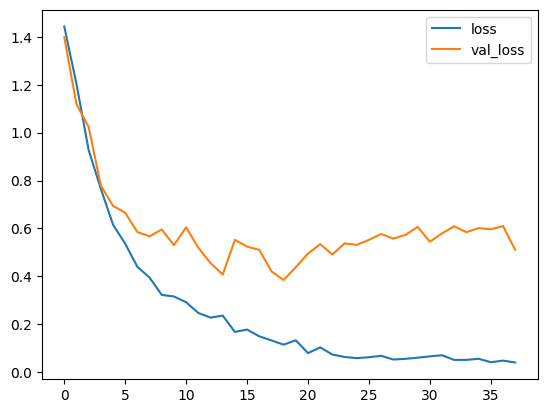

In [42]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

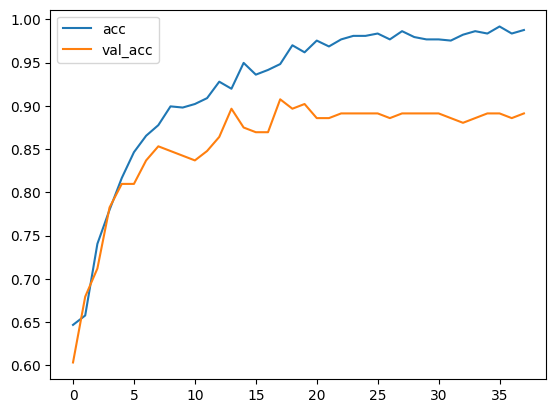

In [43]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

6/6 [==============================] - 0s 11ms/step
Confusion matrix, without normalization
[[  7   0   0   0   0   0   0   0]
 [  0  12   0   0   0   0   0   0]
 [  0   0   3   0   0   0   3   0]
 [  0   0   0  16   0   0   0   0]
 [  0   0   0   0   0   0   7   0]
 [  0   0   0   0   0  16   2   1]
 [  0   0   0   0   0   0 111   0]
 [  0   0   1   0   0   0   3   2]]


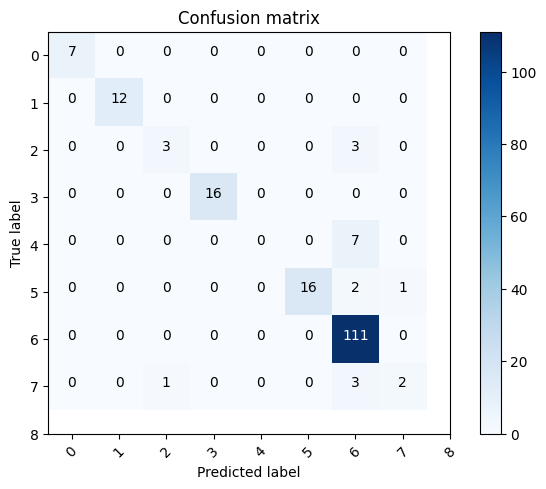

In [45]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = basemodel.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(9)))

In [ ]:
checkpoint_path

In [ ]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time

for k in range(40):
        print(f'actual label is {label_to_text[y_test[k]]}')
        predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
        print(f'predicted label is {label_to_text[predicted_class]}')
        pyplot.imshow(X_test[k].reshape((48,48)))
        pyplot.show()
        time.sleep(3)
        clear_output(wait=True)